In [14]:
import pyarrow as pa
import pyarrow_hotfix
import torch
import yaml
import argparse
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import exlib
import math

from datasets import load_dataset
from collections import namedtuple
from exlib.datasets.pretrain import setup_model_config, get_dataset, get_dataset, setup_model_config
from exlib.datasets.dataset_preprocess_raw import create_train_dataloader_raw, create_test_dataloader_raw, create_test_dataloader
from exlib.datasets.informer_models import InformerConfig, InformerForSequenceClassification
from tqdm.auto import tqdm
pa.PyExtensionType.set_auto_load(True)
pyarrow_hotfix.uninstall()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Dataset

In [2]:
# load dataset
dataset = load_dataset("BrachioLab/supernova-timeseries")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

### Model predictions

In [3]:
# load model
model = InformerForSequenceClassification.from_pretrained("BrachioLab/supernova-classification")
model = model.to(device)
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader(
    config=config,
    dataset=test_dataset,
    batch_size=2,
    compute_loss=True
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub-0.23.2-py3.8.egg/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


num labels: 14
Using Fourier PE
classifier dropout: 0.2
original dataset size: 792
remove nans dataset size: 792


In [4]:
with torch.no_grad():
    y_true = []
    y_pred = []
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        outputs = model(**batch)
        y_true.extend(batch['labels'].cpu().numpy())
        y_pred.extend(torch.argmax(outputs.logits, dim=2).squeeze().cpu().numpy())
# model prediction
print(f"accuracy: {sum([1 for i, j in zip(y_true, y_pred) if i == j]) / len(y_true)}")

  0%|          | 0/396 [00:00<?, ?it/s]

accuracy: 0.7929292929292929


### Dataset Samples

In [5]:
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader_raw(
    config=config,
    dataset=test_dataset,
    batch_size=2,
    compute_loss=True
)

original dataset size: 792
remove nans dataset size: 792


In [26]:
def plot_data_by_wavelength(times, fluxes, errors, wavelengths, title):
    unique_wavelengths = sorted(set(wavelengths))
    color_map = plt.get_cmap('rainbow')
    colors = color_map(np.linspace(0, 1, len(unique_wavelengths)))
    wavelength_to_color = {w: c for w, c in zip(unique_wavelengths, colors)}

    plt.figure(figsize=(6, 3))
    for wavelength in unique_wavelengths:
        indices = [i for i, w in enumerate(wavelengths) if w == wavelength]
        plt.errorbar([times[i] for i in indices], [fluxes[i] for i in indices], yerr=[errors[i] for i in indices],
                     fmt='o', color=wavelength_to_color[wavelength], capsize=5, label=f'{wavelength}')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.title(title)
    plt.legend(title="Wavelengths", loc='upper right', fontsize='small', title_fontsize='small')
    plt.grid(True)
    plt.show()

  0%|          | 0/396 [00:00<?, ?it/s]

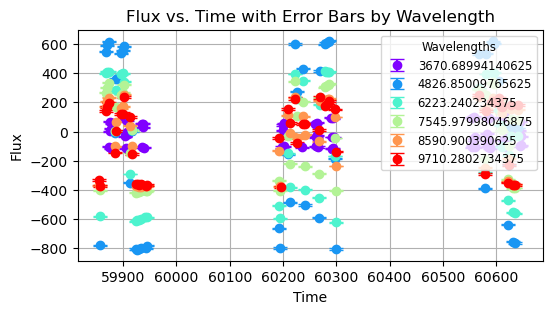

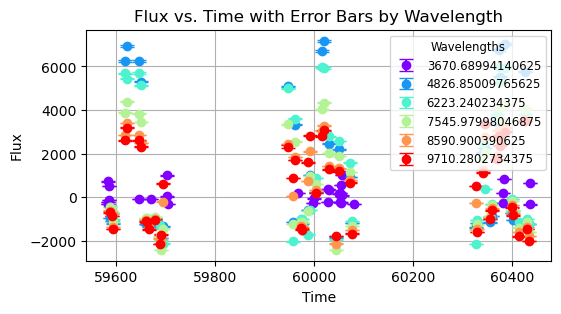

In [27]:
# dataset sample
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)

        if bi == 0:
            for j in range(len(valid_time_values_batch)):
                plot_data_by_wavelength(valid_time_values_batch[j], valid_flux_values_batch[j], 
                                        valid_flux_error_values_batch[j], valid_wavelength_values_batch[j],
                                        'Flux vs. Time with Error Bars by Wavelength')

### Ground truth

In [47]:
# dataset sample
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)

        if bi == 0:
            int_time_values_batch = []
            window_size = 15
            window_time_values_batch = []
            window_flux_values_batch = []
            for j in range(len(valid_time_values_batch)):
                unique_wavelengths = sorted(set(valid_wavelength_values_batch[j]))
                #print(unique_wavelengths)
                start = math.floor(valid_time_values_batch[j][0])
                end = math.ceil(valid_time_values_batch[j][-1])
                int_time_values_batch.append(list(range(start, end + 1)))
                window_time_values_batch.append([[int_time_values_batch_j[i], int_time_values_batch_j[i + window_size - 1]] for i in range(len(int_time_values_batch_j) - window_size + 1)])
                batch_windows = []  # This will hold all window lists for batch j
    
                # For each window in this batch
                for k in range(len(window_time_values_batch[j])):
                    # Create a list of zeros for each wavelength in this window
                    window_wavelengths = [0] * len(unique_wavelengths)
                    batch_windows.append(window_wavelengths)
            
                # Add the constructed list for this batch to the main list
                window_flux_values_batch.append(batch_windows)    

                for k in range(len(unique_wavelengths)):
                    target_wavelength = unique_wavelengths[k]
                    indices_with_target_wavelength = [i for i, wavelength in enumerate(valid_wavelength_values_batch[j]) if wavelength == target_wavelength]
                    #print("Indices with wavelength", target_wavelength, ":", indices_with_target_wavelength)    
            #print(len(window_time_values_batch), len(window_time_values_batch[j]), window_time_values_batch[j][0])
            #print(len(window_flux_values_batch), len(window_flux_values_batch[j]), len(window_flux_values_batch[j][0]))
            #print(window_flux_values_batch[j])
            #break

  0%|          | 0/396 [00:00<?, ?it/s]

### Alignment scores

In [48]:
# baseline
def baseline(valid_length):
    num_groups = (valid_length // 10) + 1
    pred_groups = []
    for group_idx in range(num_groups):
        start_index = group_idx * 10
        end_index = min((group_idx + 1) * 10, valid_length)
        group_list = [1 if start_index <= i < end_index else 0 for i in range(valid_length)]
        pred_groups.append(group_list)
    return pred_groups

In [49]:
# alignment
def process_group_pair(pred_group, true_group, device):
    pred_groups = torch.tensor(pred_group, dtype=torch.float32).to(device)
    true_groups = torch.tensor(true_group, dtype=torch.float32).to(device)
    pred_groups_bool = pred_groups.to(torch.bool)
    true_groups_bool = true_groups.to(torch.bool)
    intersections = (pred_groups_bool.unsqueeze(1) & true_groups_bool.unsqueeze(0)).float().sum(dim=2)
    unions = (pred_groups_bool.unsqueeze(1) | true_groups_bool.unsqueeze(0)).float().sum(dim=2)
    ious = intersections / unions
    ious = torch.nan_to_num(ious, nan=0.0)
    max_iou, _ = torch.max(ious, dim=1)
    avg_list = []
    for col in range(pred_groups.size(1)):
        mask = pred_groups[:, col] == 1
        if torch.any(mask):
            avg_iou = max_iou[mask].mean().item()
        else:
            avg_iou = 0
        avg_list.append(avg_iou)
    return avg_list

def calculate_alignment_scores(pred_groups_batch, true_groups_batch, device):
    alignment_scores = []
    for i in range(len(pred_groups_batch)):
        avg_list = process_group_pair(pred_groups_batch[i], true_groups_batch[i], device)
        alignment_score = sum(avg_list) / len(avg_list) if avg_list else 0
        alignment_scores.append(alignment_score)
    return alignment_scores

In [50]:
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        
        # predicted group
        valid_time_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            
            pred_groups = baseline(valid_length)
            pred_groups_batch.append(pred_groups)
            # pred_groups_batch: batch_size * pred_group_num * valid_length

        # ground truth group - need to update
        true_groups_batch = pred_groups_batch
        #true_groups_batch = [[[0.0 for _ in sub_group] for sub_group in group] for group in pred_groups_batch]

        # alignment score
        alignment_scores = calculate_alignment_scores(pred_groups_batch, true_groups_batch, device)
        alignment_scores_all.extend(alignment_scores)
# all alignment score
print(f"average alignment score: {sum(alignment_scores_all) / len(alignment_scores_all)}")

  0%|          | 0/396 [00:00<?, ?it/s]

average alignment score: 1.0
